In [1]:
import os
import shutil
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
from tempfile import TemporaryDirectory
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/Dress Masking'
test_size = 0.2
csv_path = '/content/drive/MyDrive/filtered_data_updated2.csv'

Mounted at /content/drive


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    # Wrap the dataloader with tqdm for a progress bar
    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [6]:
def val_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # Wrap the dataloader with tqdm for a progress bar
    for inputs, labels in tqdm(dataloader, desc="Validation", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [7]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, device, num_epochs=25):
    since = time.time()

    # Lists to store losses and accuracies
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Training phase
            train_loss, train_acc = train_epoch(model, dataloaders['train'], criterion, optimizer, device)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc.item())
            print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

            # Validation phase
            val_loss, val_acc = val_epoch(model, dataloaders['val'], criterion, device)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc.item())
            print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

            # Step the scheduler
            scheduler.step()

            # Save the best model
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # Load the best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    # Plotting the losses and accuracies
    plt.figure(figsize=(12, 4))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return model

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

# Load pre-trained ResNet-50
model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features

# Replace the FC layer with dropout and a new linear layer
model_ft.fc = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(num_ftrs, 2)
)

model_ft = model_ft.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Epoch 0/9
----------


Train Loss: 0.2685 Acc: 0.9373


Val Loss: 0.2508 Acc: 0.9263

Epoch 1/9
----------


Train Loss: 0.1544 Acc: 0.9591


Val Loss: 0.2323 Acc: 0.9474

Epoch 2/9
----------


Train Loss: 0.1476 Acc: 0.9510


Val Loss: 0.2143 Acc: 0.9474

Epoch 3/9
----------


Train Loss: 0.0892 Acc: 0.9728


Val Loss: 0.2885 Acc: 0.9368

Epoch 4/9
----------


Train Loss: 0.1028 Acc: 0.9619


Val Loss: 0.3020 Acc: 0.9263

Epoch 5/9
----------


Train Loss: 0.0626 Acc: 0.9837


Val Loss: 0.3502 Acc: 0.9579

Epoch 6/9
----------


Train Loss: 0.0651 Acc: 0.9782


Val Loss: 0.3371 Acc: 0.9579

Epoch 7/9
----------


Train Loss: 0.0743 Acc: 0.9755


Val Loss: 0.2879 Acc: 0.9579

Epoch 8/9
----------


Train Loss: 0.0469 Acc: 0.9809


Val Loss: 0.3004 Acc: 0.9474

Epoch 9/9
----------


Train Loss: 0.0420 Acc: 0.9837


Val Loss: 0.2748 Acc: 0.9474

Training complete in 5m 29s
Best val Acc: 0.957895


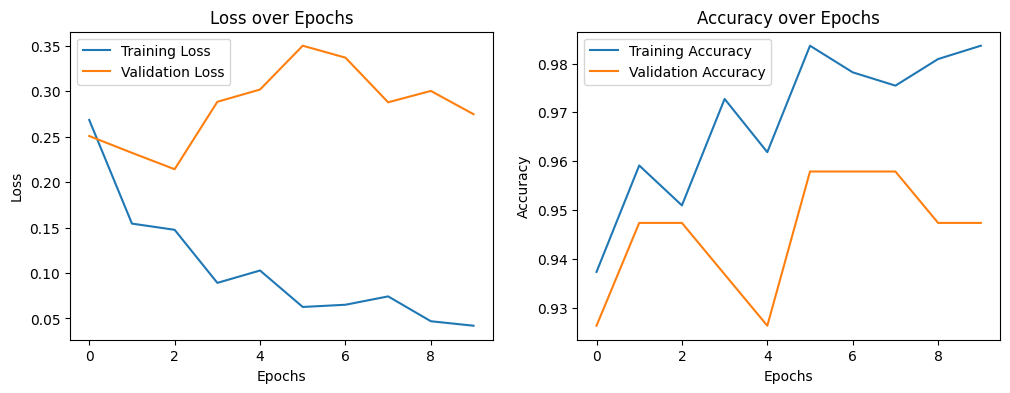

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, device, num_epochs=10)

In [20]:
torch.save(model_ft.state_dict(), 'Dress_classification.pth')